<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/DEEPAR03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Via a simple fit() call, AutoGluon can train: 

* simple forecasting models (e.g., ARIMA, ETS)
* powerful neural network-based models (e.g., DeepAR, Transformer, MQ-CNN)
* and fit greedy weighted ensembles built on these

to produce multi-step ahead probabilistic forecasts for univariate time series data.


NOTE

autogluon.timeseries depends on Apache MXNet.

In [1]:
#pip3 install -U pip
#pip3 install -U setuptools wheel

# CPU version of pytorch has smaller footprint - see installation instructions in
# pytorch documentation - https://pytorch.org/get-started/locally/
#pip3 install torch==1.12+cpu torchvision==0.13.0+cpu torchtext==0.13.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html

#pip3 install autogluon

In [2]:
!pip install mxnet>=1.9
!pip install autogluon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


This tutorial demonstrates how to quickly start using AutoGluon to produce forecasts of COVID-19 cases in a country given historical data from each country.


autogluon.timeseries provides the TimeSeriesPredictor and TimeSeriesDataFrame classes for interacting with time series models. 

TimeSeriesDataFrame contains time series data. The TimeSeriesPredictor class provides the interface for fitting, tuning and selecting forecasting models.



In [3]:
import pandas as pd
from matplotlib import pyplot as plt

from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

TimeSeriesDataFrame objects hold time series data, often with multiple “items” (time series) such as different products in demand forecasting. 
This setting is also sometimes referred to as a “panel” of time series. TimeSeriesDataFrame inherits from Pandas DataFrame, and the attributes and methods of pandas.

DataFrames are available in TimeSeriesDataFrames.

In our example, we work with COVID case data as of April 2020 where our goal is to forecast the number of confirmed COVID cases for each country in the data set. 
Below, we load time series data from an AWS S3 bucket, and prepare it for use in autogluon.timeseries. 

Note that we make sure the date field is parsed by pandas, and provide the columns containing the item (id_column) and timestamps (timestamp_column) to TimeSeriesDataFrame. 

We also plot the trajectories of COVID cases with two example countries: Germany and the UK.

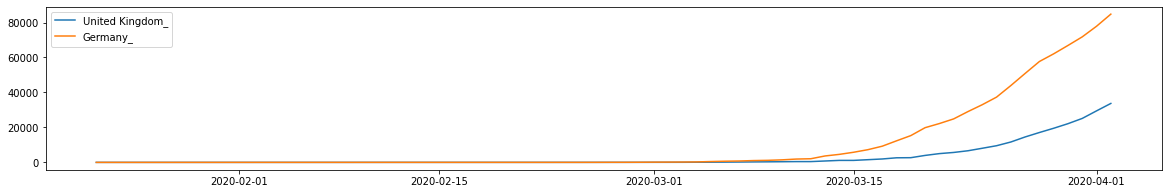

In [4]:
df = pd.read_csv(
    "https://autogluon.s3-us-west-2.amazonaws.com/datasets/CovidTimeSeries/train.csv",
    parse_dates=["Date"],
)

train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="name",
    timestamp_column="Date",
)

plt.figure(figsize=(20, 3))
for country in ["United Kingdom_", "Germany_"]:
    plt.plot(train_data.loc[country], label=country)
plt.legend()

In [5]:
train_data.head()

ConfirmedCases
item_id      timestamp                 
Afghanistan_ 2020-01-22             0.0
             2020-01-23             0.0
             2020-01-24             0.0
             2020-01-25             0.0
             2020-01-26             0.0

Note how TimeSeriesDataFrame objects organize the data with a pandas.MultiIndex where the first level of the index corresponds to the item (here, country) and the second level contains the dates for which the values were observed. 

We can also use the loc accessor, as in pandas, to access individual country data.

In [6]:
train_data.loc['Afghanistan_'].head()

,ConfirmedCases
timestamp,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0


The primary use case of autogluon.timeseries is time series forecasting. 

In our example, our goal is to train models on COVID case data that can forecast the future trajectory of cases given the past, for each country in the data set. 

By default, autogluon.timeseries supports multi-step ahead probabilistic forecasting. 
That is, multiple time steps in the future can be forecasted, given that models are trained with the prerequisite number of steps (also known as the forecast horizon). 

Moreover, when trained models are used to predict the future, the library will provide both "mean" forecasts–expected values of the time series in the future, as well as quantiles of the forecast distribution.

In order to train our forecasting models, we first split the data into training and test data sets. 

In forecasting, this is often done via excluding the last prediction_length many steps of the data set during training, and only use these steps to compute validation scores (also known as an “out of time” validation sample). 

We carry out this split via the slice_by_timestep method provided by TimeSeriesDataFrame which takes python slice objects.

In [7]:
prediction_length = 5

# the full data set
test_data = train_data.copy()  

# the data set with the last prediction_length time steps included, i.e., akin to `a[:-5]`
train_data = train_data.slice_by_timestep(slice(None, -prediction_length))

Below, for a single country we plot the training and test data sets showing how they overlap and explicitly mark the forecast horizon of the test data set. 
The test scores will be computed on forecasts provided for this range.

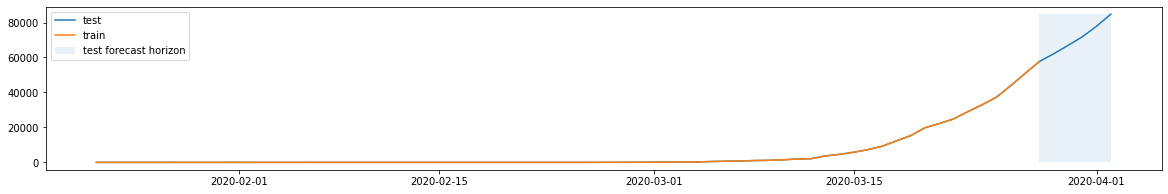

In [8]:
plt.figure(figsize=(20, 3))
plt.plot(test_data.loc["Germany_"], label="test")
plt.plot(train_data.loc["Germany_"], label="train")

test_range = (
    test_data.loc["Germany_"].index.max(),
    train_data.loc["Germany_"].index.max(),
)

plt.fill_betweenx(
    y=(0, test_data.loc["Germany_"]["ConfirmedCases"].max()),
    x1=test_range[0],
    x2=test_range[1],
    alpha=0.1,
    label="test forecast horizon",
)

plt.legend()

Below we instantiate a TimeSeriesPredictor object and instruct AutoGluon to fit models that can forecast up to 5 time-points into the future (prediction_length) and save them in the folder ./autogluon-covidforecast. 


We also specify that AutoGluon should rank models according to mean absolute percentage error (MAPE) and that the target field to be forecasted is “ConfirmedCases”.

In [9]:
predictor = TimeSeriesPredictor(
    path="autogluon-covidforecast",
    target="ConfirmedCases",
    prediction_length=prediction_length,
    eval_metric="MAPE",
)
predictor.fit(
    train_data=train_data,
    presets="low_quality",
)

INFO:autogluon.timeseries.predictor:presets is set to low_quality
INFO:autogluon.timeseries.predictor:================ TimeSeriesPredictor ================
INFO:autogluon.timeseries.predictor:TimeSeriesPredictor.fit() called
INFO:autogluon.timeseries.predictor:Setting presets to: low_quality
INFO:autogluon.timeseries.predictor:Fitting with arguments:
INFO:autogluon.timeseries.predictor:{'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'toy',
 'prediction_length': 5,
 'target_column': 'ConfirmedCases',
 'time_limit': None}
INFO:autogluon.timeseries.predictor:Provided training data set with 20971 rows, 313 items. Average time series length is 67.0.
INFO:autogluon.timeseries.predictor:Training artifacts will be saved to: /content/autogluon-covidforecast
INFO:autogluon.timeseries.predictor:=====================================================
INFO:autogluon.timeseries.trainer:
Starting training. Start time is 2022-09-30 10:56:30
INFO:autogluon.timeserie

In a short amount of time AutoGluon fits four time series forecasting models on the training data. 

These models are three neural network forecasters: DeepAR, MQCNN, a simple feedforward neural network, and a simple exponential smoothing model with automatic parameter tuning: Auto-ETS. 

AutoGluon also constructs a weighted ensemble of these models capable of quantile forecasting.

We can view the test performance of each model AutoGluon has trained via the leaderboard() method. 

We provide the test data set to the leaderboard function to see how well our fitted models are doing on the held out time frame. 

In AutoGluon leaderboards, higher scores always correspond to better predictive performance. 
Therefore our MAPE scores are presented with a “flipped” sign, such that higher “negative MAPE”s correspond to better models.

In [10]:
predictor.leaderboard(test_data, silent=True)

INFO:autogluon.timeseries.trainer:Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,SimpleFeedForward,-0.181031,-0.349431,2.263331,2.164552,6.064228,2
1,WeightedEnsemble,-0.224415,-0.315940,50.219230,52.292770,200.049981,6
2,AutoETS,-0.247532,-0.328701,43.898949,44.947295,10.220143,1
3,DeepAR,-0.267786,-0.429464,5.376025,5.180923,11.052577,3
4,ARIMA,-0.286547,-0.366499,70.183752,51.965482,14.289503,4
5,Transformer,-0.321885,-1.123790,5.363759,5.254678,10.872283,5


We can now use the TimeSeriesPredictor to look at actual forecasts. 
By default, AutoGluon will select the best performing model to forecast time series with. 
Let’s use the predictor to compute forecasts, and plot forecasts for an example country.

In [11]:
predictions = predictor.predict(train_data)

INFO:autogluon.timeseries.trainer:Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


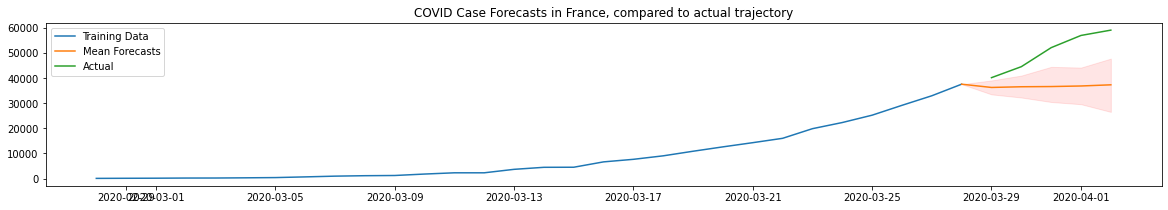

In [12]:
plt.figure(figsize=(20, 3))

ytrue = train_data.loc['France_']["ConfirmedCases"]
ypred = predictions.loc['France_']

# prepend the last value of true range to predicted range for plotting continuity
ypred.loc[ytrue.index[-1]] = [ytrue[-1]] * 10
ypred = ypred.sort_index()

ytrue_test = test_data.loc['France_']["ConfirmedCases"][-5:]

plt.plot(ytrue[-30:], label="Training Data")
plt.plot(ypred["mean"], label="Mean Forecasts")
plt.plot(ytrue_test, label="Actual")

plt.fill_between(
    ypred.index, ypred["0.1"], ypred["0.9"], color="red", alpha=0.1
)
plt.title("COVID Case Forecasts in France, compared to actual trajectory")
_ = plt.legend()

As we used a “toy” presets setting (presets="low_quality") our forecasts may appear to not be doing very well. 

In realistic scenarios, users can set presets to be one of: "best_quality", "high_quality", "good_quality", "medium_quality". 
Higher quality presets will generally produce superior forecasting accuracy but take longer to train and may produce less efficient models.